In [1]:
% pylab inline
figsize(10, 8)

import sys
sys.path.append("/Users/humphreyshotton/ds/twicol")

Populating the interactive namespace from numpy and matplotlib


In [8]:
from pymongo import MongoClient
from Polygon import Polygon
from Polygon import Error as PolygonError

from geopy.distance import vincenty

# connect to mongodb
client = MongoClient("localhost", 27017)
db = client["twitter"]

# get the tweet cursor
cursor = db.tweets.find({'locinf.mi.test': {'$ne': None}})

real_loc = []
inf_loc = []
inf_poly = []
distances = []
distances2 = []
weights = []
insides = []
usernames = []
totalcount = 0
count = 0
nocount = 0

for doc in cursor:
    totalcount += 1
    if doc["geo"] is None:
        continue

    # get the real point
    point = (doc["geo"]["coordinates"][1], doc["geo"]["coordinates"][0])
    # get the poly
    poly = eval(doc["locinf"]["mi"]["test"]["poly"])

    centres = []
    
    p = Polygon()
    for i in poly:
        p.addContour(i)

    try:
        center = p.center()
    except PolygonError:
        nocount += 1
        continue

    inside = p.isInside(point[0], point[1])
    
    distance1 = vincenty(point, center).km
    distance2 = vincenty((point[1], point[0]), (center[1], center[0])).km
    
    real_loc.append(point)
    inf_loc.append(center)
    inf_poly.append(poly)
    weights.append(doc["locinf"]["mi"]["test"]["weight"])
    distances.append(distance2)
    distances2.append(distance1)
    insides.append(inside)
    usernames.append(doc["user"]["screen_name"])

    count += 1
    if count % 1000 == 0:
        print("Processed", count)
    #print("Inside:", ('Y' if inside else 'N'), "- Distance:", distance)

print("Mean distance from polygon center:", sum(distances) / len(distances))
print("Fraction within polygon:", sum(insides) / len(insides))
print("Classified:", (count-nocount) / count)

Processed 1000
Processed 2000
Processed 3000
Processed 4000
Processed 5000
Processed 6000
Processed 7000
Processed 8000
Processed 9000
Processed 10000
Processed 11000
Mean distance from polygon center: 607.472752072
Fraction within polygon: 0.836835933977
Classified: 0.9784432217912871


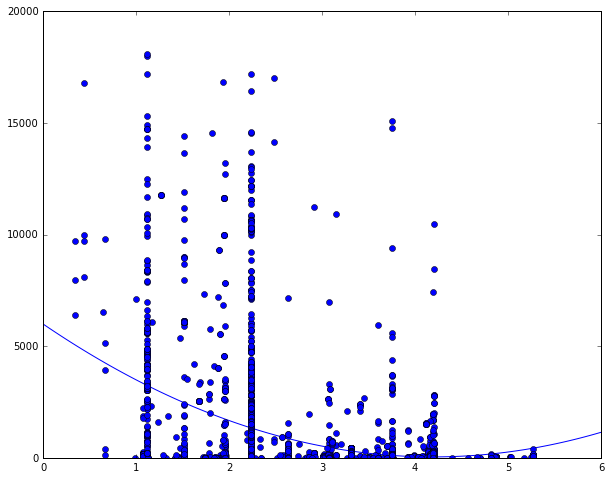

In [9]:
np_weights = []
np_distances = []
for i in range(count):
    if weights[i] is not None:
        np_weights.append(weights[i])
        np_distances.append(distances[i])

z = np.polyfit(np_weights, np_distances, 2)
f = np.poly1d(z)

x_new = np.linspace(0, 6, 100)
y_new = f(x_new)

plot(x_new, y_new)
plot(np_weights, np_distances, 'bo')

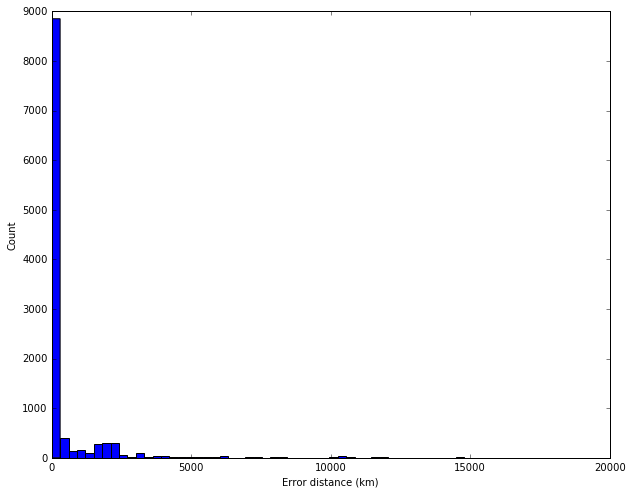

In [10]:
xlabel('Error distance (km)')
ylabel('Count')
h = hist(distances, bins=60)

In [11]:
(mean(distances), median(distances)), (mean(distances2), median(distances2))
# ((607.47275207212408, 138.16827068812421), (1491.7463407028906, 180.34902237074951))

((607.47275207212408, 138.16827068812421),
 (1491.7463407028906, 180.34902237074951))

In [12]:
from collections import defaultdict

counts = defaultdict(int)
for i in usernames:
    counts[i] += 1

user_dict = counts
items = counts.items()
items = sorted(items, key=lambda x: -x[1])
print(items)

[('RiverlevelsUK', 4709), ('IFIS_Warnings', 1954), ('FloodAlerts', 501), ('DailyCUMBRIA', 139), ('iembot_bmx', 105), ('AlabamaWxTeam', 103), ('BaySARteam', 83), ('iembot_pqr', 70), ('CumbriaTravel', 61), ('sp_Louisiana', 52), ('iembot_sgf', 50), ('Dedwards131', 49), ('CarolinaWx', 49), ('riverlevel_0018', 49), ('northyorktravel', 47), ('iembot_gsp', 43), ('TotalTrafficSEA', 39), ('NWSAtlanta', 36), ('qcweather', 35), ('WestYorksTravel', 34), ('riverlevel_0905', 34), ('sp_rhodeisland', 29), ('BeepBeepTraffic', 28), ('trendinaliaGB', 27), ('iembot_shv', 27), ('iembot_lsx', 27), ('iembot_hun', 26), ('iembot_rlx', 26), ('sp_connecticut', 25), ('riverlevel_1816', 25), ('_EurekaCA', 24), ('NWSFortWorth', 23), ('SeattleCP', 21), ('sp_ny', 20), ('_DelMarCA', 20), ('_LaJollaCA', 20), ('VistaCA', 20), ('sp_wisconsin', 20), ('_SanDiegoCA', 20), ('riverlevel_0069', 20), ('iembot_jkl', 20), ('EncinitasCA', 20), ('_OceansideCA', 20), ('sactraffic', 19), ('baltimore311', 19), ('TotalTrafficNYC', 18),

(1998.8802076965337, 605.23863196239176)

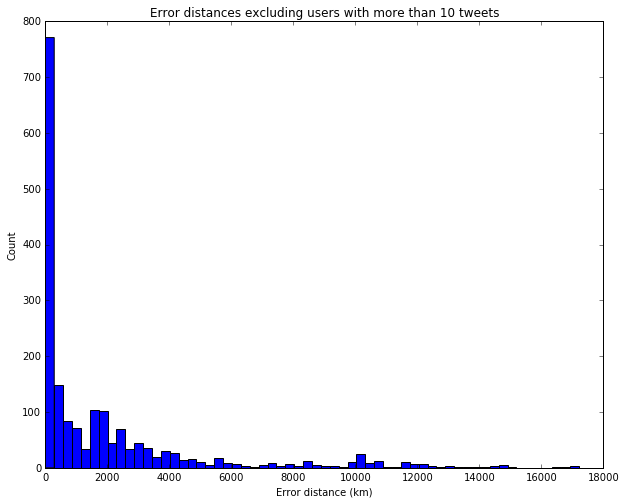

In [13]:
def distanceslimited(count):
    nd = []
    for i in range(len(usernames)):
        if user_dict[usernames[i]] < count:
            nd.append(distances[i])
    return asarray(nd)

count_limit = 10
new_distances = distanceslimited(count_limit)

title('Error distances excluding users with more than %i tweets' % count_limit)
xlabel('Error distance (km)')
ylabel('Count')
h = hist(new_distances, bins=60)

mean(new_distances), median(new_distances)

In [14]:
from implementation.multiind.polystacker import plot_area

inf_poly_weights = []
for i in range(len(weights)):
    if user_dict[usernames[i]] > 50:
        continue
        
    if inf_poly[i] is not None and weights[i] is not None:
        inf_poly_weights.append([(inf_poly[i][x], weights[i]) for x in range(len(inf_poly[i]))])

res = plot_area(inf_poly_weights)

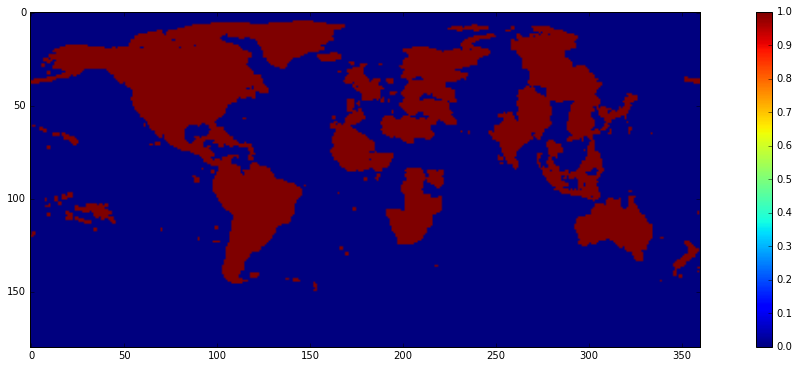

In [15]:
res_m = clip(res[0], 0, 1)

figsize(20, 6)
imshow(res_m)
colorbar(orientation='vertical')

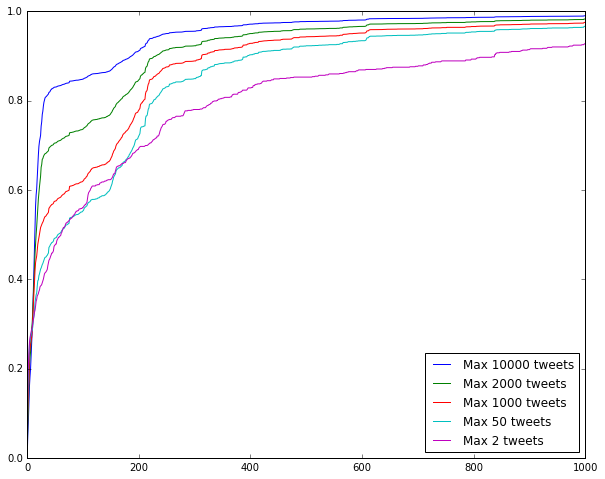

In [16]:
def acck(d, k):
    return sum(d <= k) / len(d)

figsize(10, 8)

tests = [10000, 2000, 1000, 50, 2]
for i in tests:
    dis = distanceslimited(i)
    plot([acck(dis, k) for k in range(0, 10000, 10)], label='Max %i tweets' % i)

legend(loc=4)

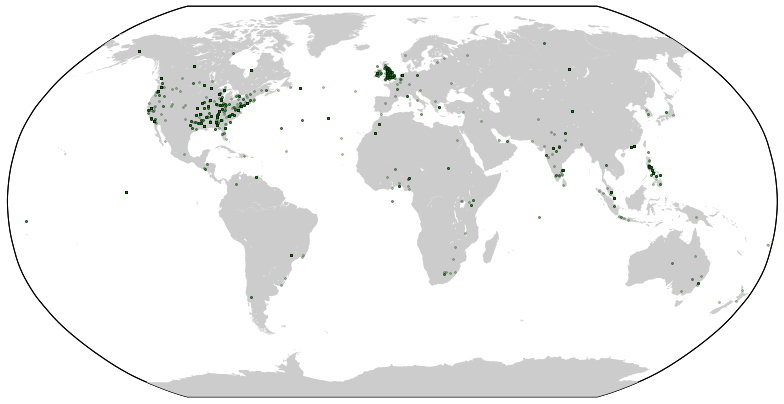

In [17]:
from mpl_toolkits.basemap import Basemap

fig = figure(figsize=(14,7))
ax = fig.add_subplot(111, frame_on=False)
mp = Basemap(projection='robin', lat_0=0, lon_0=0,
              resolution='l', area_thresh=1000.0)

for p in inf_loc:
    if p is None: 
        continue
    x,y = mp(p[0], p[1])
    mp.plot(x, y, 'o', markersize=2, color='green', alpha=0.4)

#mp.drawcoastlines()
#mp.drawcountries()
mp.fillcontinents(color='#CCCCCC')#, zorder=0)
mp.drawmapboundary()

plt.savefig('map-points.png', dpi=200, alpha=True)

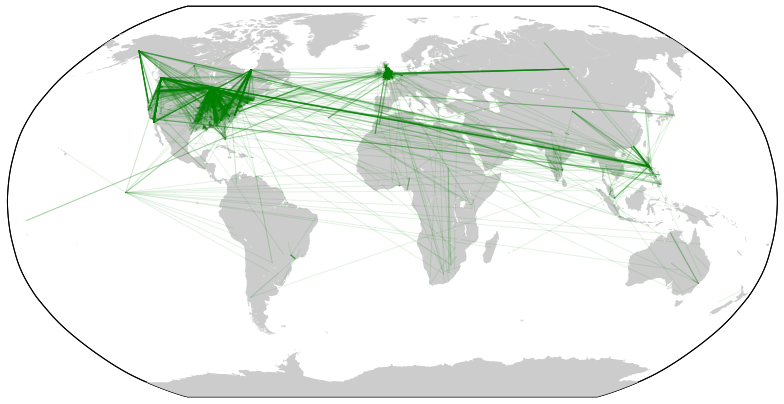

In [18]:
fig = figure(figsize=(14,7))
ax = fig.add_subplot(111, frame_on=False)
mp = Basemap(projection='robin', lat_0=0, lon_0=0,
              resolution='l', area_thresh=1000.0)

for p in range(len(inf_loc)):
    if real_loc[p] is None or inf_loc[p] is None: 
        continue
        
    x1, y1 = mp(real_loc[p][0], real_loc[p][1])
    x2, y2 = mp(inf_loc[p][0], inf_loc[p][1])
    
    mp.plot((x1, x2), (y1, y2), 'b', color='green', alpha=0.1)

#mp.drawcoastlines()
#mp.drawcountries()
mp.fillcontinents(color='#CCCCCC')#, zorder=0)
mp.drawmapboundary()

plt.savefig('map-lines2.png', dpi=400, alpha=True)